
# BPM Analysis Simulations

In [1]:

import json
import xtrack as xt
import xpart as xp
import xobjects as xo
import PyNAFF
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

context = xo.ContextCpu()

collider = xt.Multiline.from_json('../data/collider_thin.json')

line = collider['lhcb1']
for ii in line.elements:
   # if ii is a type 'multipole' 
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0

line.vars['i_oct_b1'] = 0
#line.vars['i_sext_b1'] = 0

line_edited = line.copy()
plt.close('all')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


## One particle initialization and inserstion of the BPM monitors


In [3]:
#Only one particle
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
line.particle_ref = my_particle
num_turns = 2000
sampling_frequency = 11245.5

num_particles = 3
monitor_ip3 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
line.insert_element(index='ip3', element=monitor_ip3, name='mymon3')
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')




line.build_tracker()


monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=num_turns,
                              num_particles=num_particles)
line.track(my_particle, num_turns=num_turns, freeze_longitudinal=True)

aux = line.twiss()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.


In [4]:
monitors = {}  # Create an empty dictionary to store the monitors

monitor_names = []
line_edited.discard_tracker()
for jj, ii in enumerate((['ip3']+list(aux[:, 'bpm.*']['name']))):
    monitor_name = f"mymon_{ii.replace('.', '_')}"
    monitor_names.append(monitor_name) 
    monitors[monitor_name] = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, num_particles=num_particles)
    line_edited.insert_element(index=ii,
                                element=monitors[monitor_name], 
                                name=monitor_name)

## Exciter with sine modulation at 10 Hz

In [6]:
# Exciter is working
f = 10
phi = 0
A = 1
sampling_frequency = 11245.5
total_time = num_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)


exciter = xt.Exciter(_context = context,
    samples = samples,
    sampling_frequency = sampling_frequency,
    #duration = 0.05,  # defaults to waveform duration   in sec, checked with the number of turns 0.05*11245.5=562.275
    duration= num_turns/sampling_frequency,
    frev = sampling_frequency,
    #start_turn = num_turns/10,  # default, seconds
    #start_turn = 500*1/sampling_frequency ,  
    #knl = [0.00000001],  # default, no kick
    knl = [0.001]
     # default, no kick
    #knl = [1],
    #ksl = []
)

line_edited.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

#insertion of the element in the beamline, the phase should be broken due to the kick



['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [7]:

line_edited.particle_ref = my_particle
line_edited.discard_tracker()
line_edited.build_tracker()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
# the line is then edited to include BPMs and the bunch is tracked again
# the BPMs are then used to calculate the emittance of the bunch 
particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])

particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])
#particle_0 = xp.Particles(
                 #   mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=0.003)


# generates a matched gaussian bunch and tracks it through the line

#particles = xp.generate_matched_gaussian_bunch(line=line,
                                           #    num_particles=num_particles,
                                           #    nemitt_x=2.5e-6,
                                           #    nemitt_y=2.5e-6,
                                           #    sigma_z=9e-2, particle_ref=particles)
line_edited.track(particles, num_turns=num_turns, freeze_longitudinal=True)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
line_edited.get_s_position(at_elements='mymon_bpmw_4l3_b1')

26636.4387

15000


"\nx = np.fft.fft(x_list_all)\n\nplt.xlabel('s [m] x number turn')\nplt.ylabel('x [m]')\nplt.title('x position of one particle at all BPMs')\nprint(len(x_list0))\nplt.show()\n\n#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))\nfft_try = np.fft.fft(x_list0) # fft of one monitor for all turns\nfft_try = fft_try/len(fft_try)*2 #normalization\nfft = fft_try.real + 1j*fft_try.imag \n# \nfft_used = abs(fft) - np.mean(abs(fft))\n#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))\n#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))\n\nfreq_try  =  np.linspace(0, sampling_frequency, len(fft_used))\n"

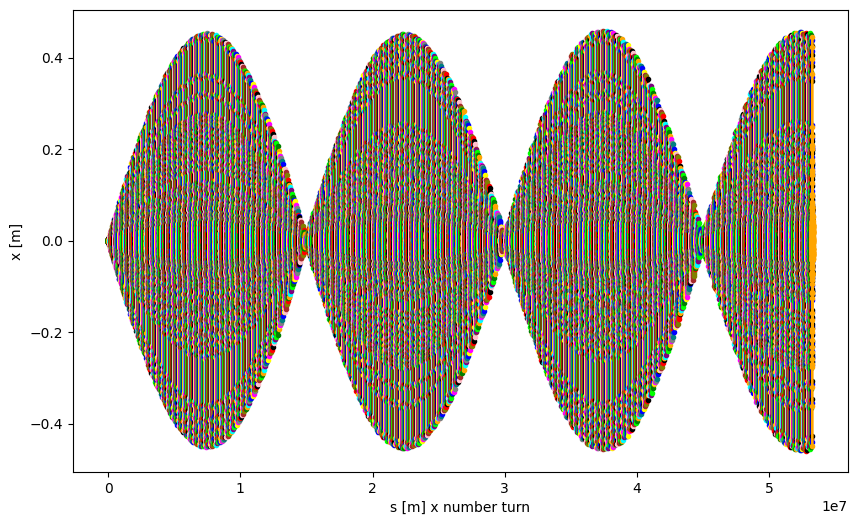

In [11]:

plt.figure(figsize=(10, 6))
n = np.arange(0, num_turns)
twiss = line_edited.twiss()
mux = twiss[:,'mymon.*'].mux
betx = twiss[:,'mymon.*'].betx
x_list_all = []
x_list0 = []  
s_list0 = []
x_list_norm = []
mux_all = []
c = 1000*['red', 'green', 'blue', 'black', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'purple', 'gray', 'olive', 'lime', 'teal']
print(len(c))
data_list = []
x_mon = []
x_list_all_app = []
x_list_norm_app = []
s_list_all = []
x_list_clean = []


if True:
    for jj in n:
        x_list = [monitors[ii].x[0,jj] for ii in monitors]   #monitors[ii].x[i,j], i is the particle number, j is the turn number
        mean_x = np.mean(x_list)
        #std_dev = abs(0.1 * mean_x)  # 1% of the mean
        std_dev = 0.001
        noise = np.random.normal(0, std_dev, len(monitor_names))   #white noise generation
        
        x_list_clean.append(x_list)
        x_list = x_list + noise                                    #adding noise to the signal

        s_list = [monitors[ii].s[0,jj] for ii in monitors]
        x_list_all.extend(x_list)
        x_list_norm.extend(x_list/np.sqrt(betx))
        x_list_all_app.append(x_list)                #transverse x position, not normalized for all turns and bpms
        x_list_norm_app.append(x_list/np.sqrt(betx)) #transverse x position, normalized by the beta function for all turns and bpms


        mon = monitors['mymon_ip3'].x[0,jj]          #just the first particle, one monitor for all turns, tranverse x position
        mon_position = monitors['mymon_ip3'].s[0,jj] #just the first particle, one monitor for all turns s position (on the ring scaled by the number of turns)
      
        x_list0.append(mon)  
        s_list0.append(mon_position) #
        mux_all.append(mux + mux[-1]*(jj))           #all mux for all turns, one turn all monitors, second turn all monitors, etc
        s_list_all.append(s_list + jj*s_list[-1])    #all s for all turns, one turn all monitors, second turn all monitors, etc
        plt.plot((s_list + jj*s_list[-1]), x_list, '.-', color=c[jj])
plt.xlabel('s [m] x number turn')
plt.ylabel('x [m]')

## Example one FFT (small check)

(0.0, 100.0)

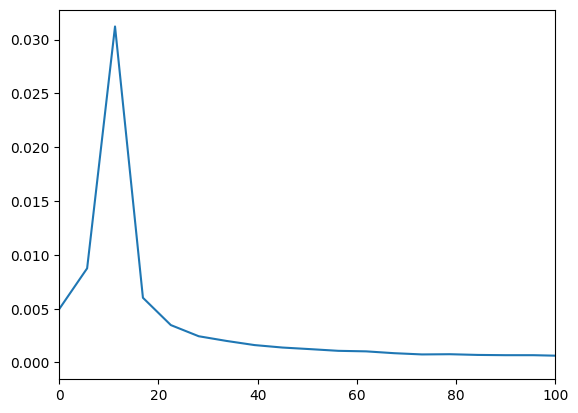

In [12]:
one_fft = np.fft.fft(x_list_all[0::568])
one_fft = one_fft/len(one_fft)*2
one_freq = np.linspace(0, sampling_frequency, len(one_fft))
plt.figure()
plt.plot(one_freq, abs(one_fft))
plt.xlim(0, 100)


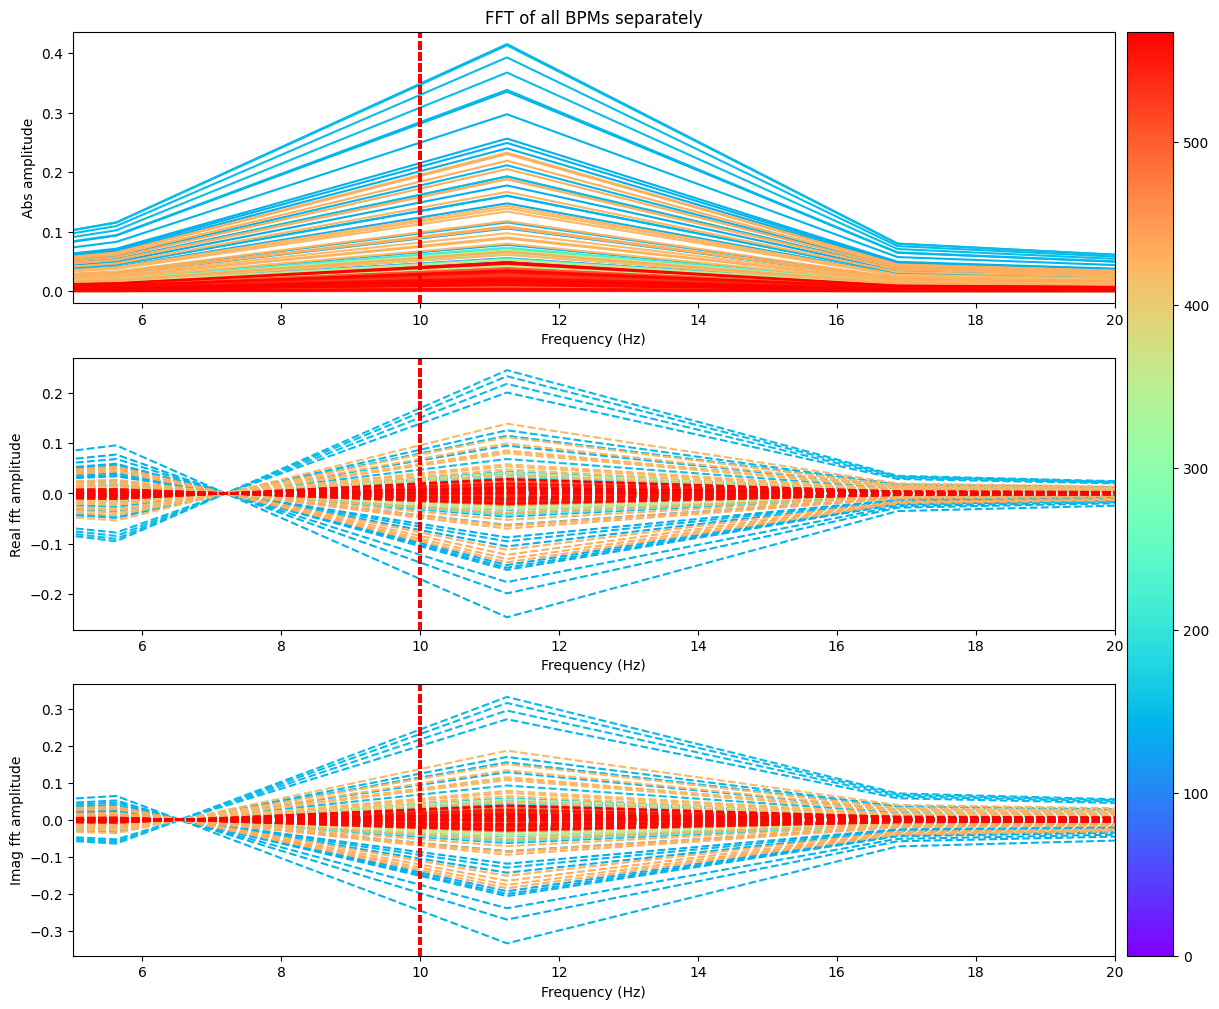

mean of abs complex in the loop 0.03419730743082015
mean of abs complex 0.021649417373865516


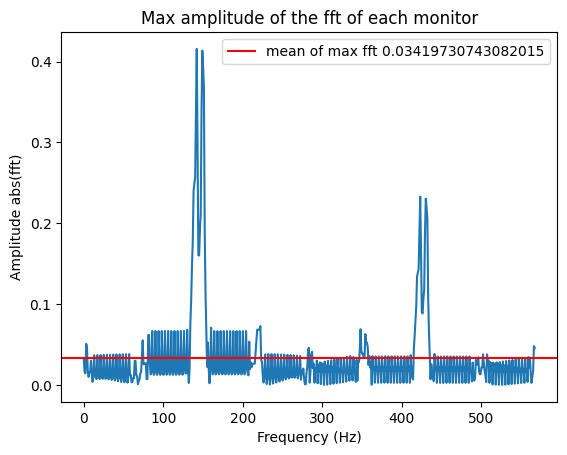

SNR of raw data (transverse position x) = 33.27747334975646 with stdv white noise = 0.001. We compute in order to estimate the closest SNR to the real data


In [13]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(monitor_names))))

sm = cm.ScalarMappable(cmap=cm.rainbow)
sm.set_clim(0, len(monitor_names))

fft_all = []
average_fft = np.zeros(num_turns, dtype=complex)
fft_all_abs = []
average_fft_abs = np.zeros(num_turns)
max_fft_all = []
max_fft_2_all = []
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

for i in range(len(monitor_names)):
    c = next(color)

    fft = np.fft.fft(x_list_all[i::568]-np.mean(x_list_all[i::568]))
    fft = fft/len(fft)*2                                      #normalization
    fft = np.round(fft, 6)                              
    freq = np.linspace(0, sampling_frequency, len(fft))
    fft_all.append(fft)
    fft_all_abs.append(abs(fft))
    average_fft_abs = average_fft_abs + abs(fft)                   #just summed up all the abs of the ffts
    average_fft  = average_fft + fft                               #just summed up all the complex ffts
    max_fft = np.max(abs(fft))
    max_fft_all.append(max_fft)
    max_fft_2 = np.max(fft)
    max_fft_2_all.append(max_fft_2)
    plt.subplot(3, 1, 1)
    plt.axvline(x = 10, color='r', linestyle='--', label='10 Hz')
    plt.plot(freq, abs(fft), c=c)
    plt.xlim(5, 20)
    plt.title('FFT of all BPMs separately')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Abs amplitude')

    plt.subplot(3,1,2)
    plt.axvline(x = 10, color='r', linestyle='--', label='10 Hz')
    plt.plot(freq, fft.real, c=c, linestyle='--')
    plt.xlim(5, 20)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Real fft amplitude')
    
    plt.subplot(3, 1, 3)
    plt.axvline(x = 10, color='r', linestyle='--', label='10 Hz')
    plt.plot(freq, fft.imag, c=c, linestyle='--')
    plt.xlim(5, 20)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Imag fft amplitude')
   
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', pad=0.01)
plt.show()

plt.plot(max_fft_all)
plt.axhline(y=np.mean(max_fft_all), color='r', linestyle='-', label=f'mean of max fft {np.mean(max_fft_all)}')
print('mean of abs complex in the loop', np.mean(max_fft_all))
print('mean of abs complex', np.mean(abs(np.array(max_fft_2_all))))      # different than the mean of the max of the abs since
                                                                         # adding complex numbers and adding abs numbers are different!!!
plt.title('Max amplitude of the fft of each monitor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude abs(fft)')
plt.legend()
plt.show()

# Calculate the power of the clean signal (without noise)
signal_power_raw = np.mean(np.abs(x_list_clean) ** 2)


# Calculate the power of the noisy signal (including both signal and noise)
signal_power_raw_noisy = np.mean(np.abs(x_list_all) ** 2)

# Calculate the noise power as the difference between the two
noise_power = signal_power_raw_noisy - signal_power_raw

# Calculate SNR in decibels (dB)
SNR_raw = 10 * np.log10(signal_power_raw / noise_power)

print(f'SNR of raw data (transverse position x) = {SNR_raw} with stdv white noise = {std_dev}. We compute in order to estimate the closest SNR to the real data')

plt.show()



 ## Performed average per BPM

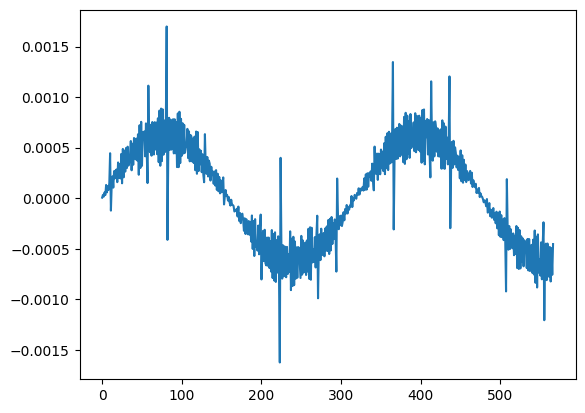

(0.0, 10.0)

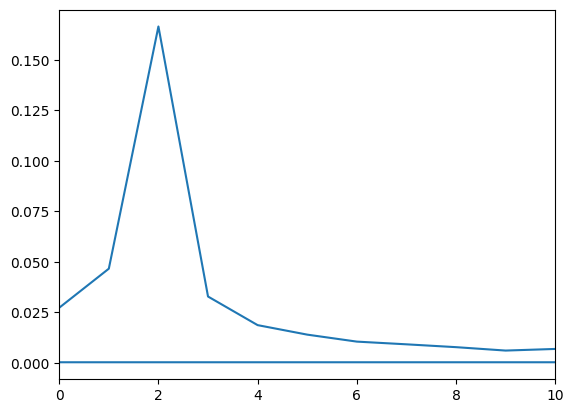

In [14]:
average_bpm_all = []
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

for i in range(len(monitor_names)-1):

    average_bpm = np.mean(x_list_all[(i +1)* 2000:(i + 2) * 2000])                 #mean of the signal for each bpm
    average_bpm_all.append(average_bpm)
plt.plot(average_bpm_all)
fft_average = np.fft.fft(average_bpm_all)
freq_average = np.fft.fftfreq(len(average_bpm_all), d = 1/len(average_bpm_all))
plt.show()
plt.plot(freq_average, abs(fft_average))
plt.xlim(0, 10)   # the resolution is sampling_frequency/points (bpms) = 11245.5/568 ~ 20 Hz 

max 0.3339539151589635
max avg_abs 19.422786813156982


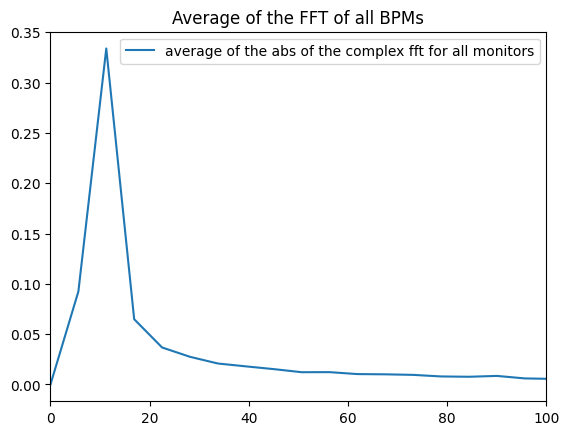

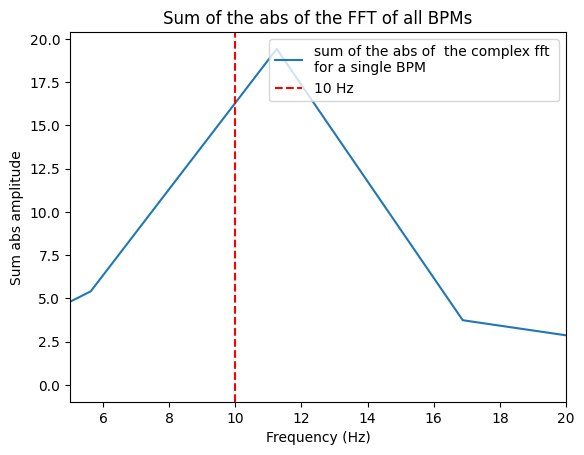

In [15]:

abs_avg = abs(average_fft)
print('max', np.max(abs_avg))

plt.plot(freq, abs_avg, label = 'average of the abs of the complex fft for all monitors')
plt.title('Average of the FFT of all BPMs')
plt.legend()
plt.xlim(0, sampling_frequency/2)
plt.xlim(0,100)
plt.figure()

avg_abs = 0
avg_abs = average_fft_abs
print('max avg_abs', np.max(avg_abs))
plt.title('Sum of the abs of the FFT of all BPMs')
plt.plot(freq, avg_abs, label = 'sum of the abs of  the complex fft \nfor a single BPM')
plt.xlim(5,20)
plt.axvline(x = 10, color = 'r', linestyle = '--', label = '10 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sum abs amplitude')
plt.legend(loc = 'upper right')





Text(0, 0.5, 'x / $\\sqrt{betx}$')

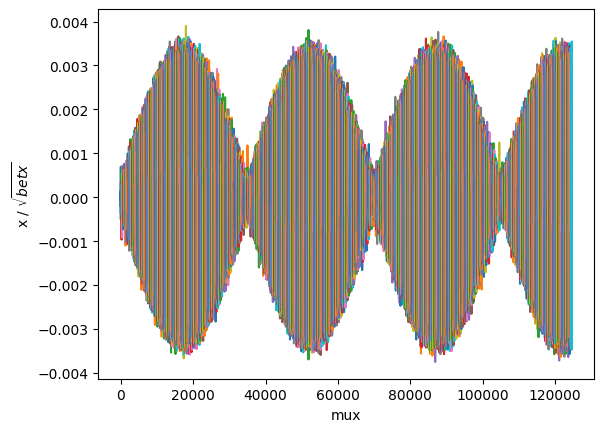

In [16]:
for i in range(len(mux_all)):
    plt.plot(mux_all[i], x_list_norm_app[i])

plt.xlabel('mux')
plt.ylabel('x / $\sqrt{betx}$')

## Visualisation of the 10 Hz oscillation for each bpm for all the turns

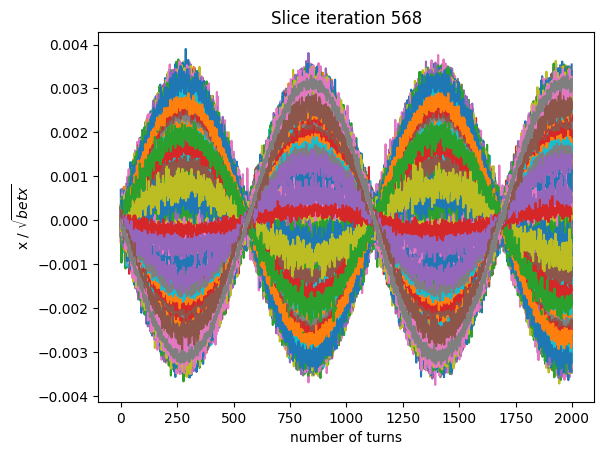

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Determine the number of iterations based on the slice size (568 elements)
slice_size = 568
num_iterations = len(x_list_norm) // num_turns

# Create a figure for the animation
fig, ax = plt.subplots()
offsets = np.arange(0, len(monitor_names))

counter = 0
# Iterate through slices and display as an animation
for offset in offsets:

    counter += 1
    slice_data = x_list_norm[offset::slice_size]
    ax.plot(slice_data)
    plt.xlabel('number of turns')
    plt.ylabel('x / $\sqrt{betx}$')
    ax.set_title(f'Slice iteration {counter}')
    display(fig)
    clear_output(wait=True)
    time.sleep(0.1)  # Adjust the delay as needed to control the animation speed


#plt.show()


Text(0, 0.5, 'x [m]')

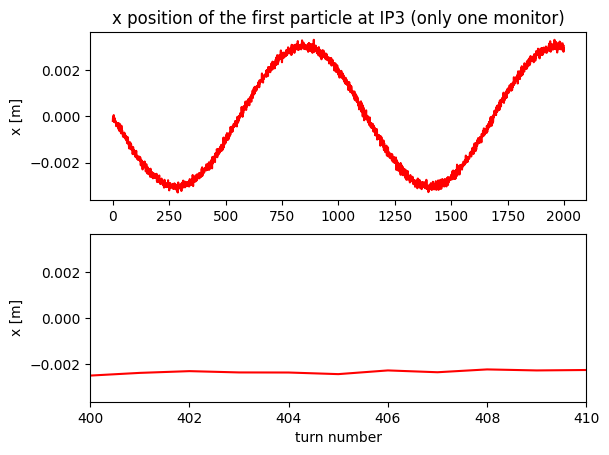

In [18]:
plt.subplot(2,1,1)
plt.title('x position of the first particle at IP3 (only one monitor)')
plt.plot(np.arange(num_turns), x_list_norm[0::568], '-r') 
plt.ylabel('x [m]')
plt.subplot(2,1,2)
plt.plot(np.arange(num_turns), x_list_norm[0::568], '-r')
plt.xlim(400, 410)
plt.xlabel('turn number')
plt.ylabel('x [m]')


amplitude_fit 0.0010625596683395532
frequency_fit 0.9999772710051313


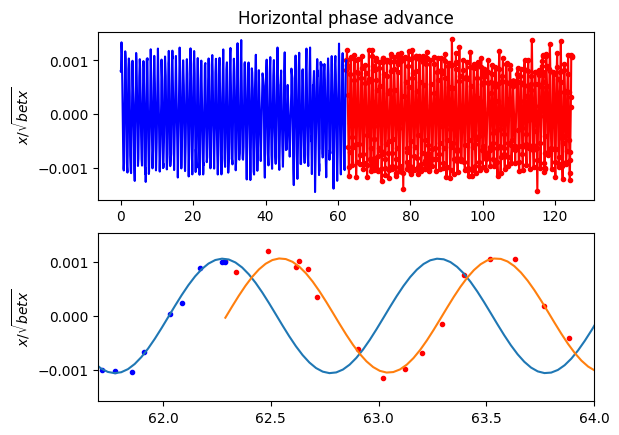

In [19]:
mux = twiss[:,'mymon.*'].mux
n= -100

y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters
fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)

# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1
x_fine = np.linspace(min(mux), 2 * max(mux), 4000)
# Generate the fitted curve using the fitted parameters

y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)

plt.subplot(2,1,1)
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.subplot(2,1,2)
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1]/2, y_fine_1)
plt.xlim(61.7, 64)
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)

# Localization of the broken phase
 - One can find a period where the phase is not broken and fit the function, then one extends the fit for all the data and looks where the error grows.
 - Due to the small number of data points (BPMs) a more fine grid is implemented and the closest phase value localized.
 - This value is then compared to the horizontal displacement and the fit horizontal displacement without a broken phase
 - Clearly the breaking in the phase can be seen exactly as expected

Text(0, 0.5, '$x/\\sqrt{betx}$ - $x_{fit}$')

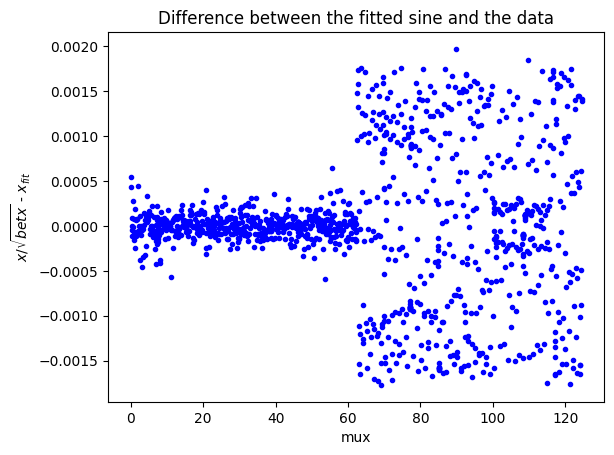

In [20]:
#% find the closest x_fine value to mux
closest_ind_all = []
x_close_all = []
y_close_all = []
y_diff = []
y_diff0 = []
mux = twiss[:,'mymon.*'].mux
mux = np.append(mux, mux + mux[-1])
for i in range(len(mux)):
    y_close = []
    closest_ind = []
    x_close = []
    closest_ind = np.argmin(np.abs(x_fine - (mux[i])))
    closest_ind_all.append(closest_ind)
    x_close = x_fine[closest_ind]
    x_close_all.append(x_close)
    y_close = y_fine[closest_ind]
    y_close_all.append(y_close)
    
y_diff_all = []
y_diff = y_data - y_close_all[len(y_data):]
y_diff0 = y_data_0 - y_close_all[:len(y_data)]
y_diff_all = np.append(y_diff0, y_diff)
for i in range(len(y_diff_all)):
    if i > 1e-10:
        plt.plot(mux[i], y_diff_all[i], '.b')
plt.title('Difference between the fitted sine and the data')
plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$ - $x_{fit}$')

## Zero padding example

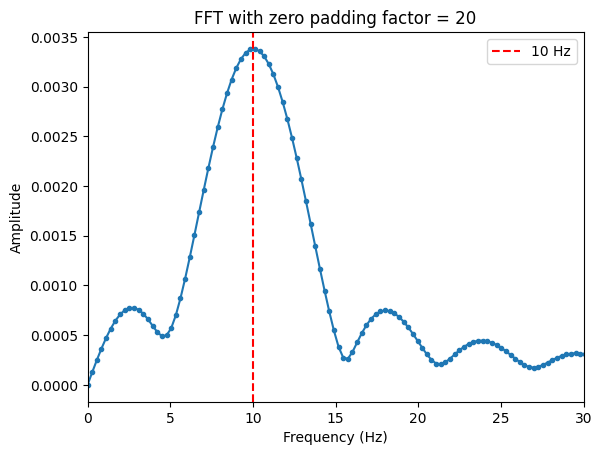

10 Hz 10.120949999999999


In [28]:
# Zero padding
zero_padding_factor = 20
fft_try = np.fft.rfft(x_list0-np.mean(x_list0), n = len(x_list0) * zero_padding_factor)

# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.rfftfreq(len(x_list0) *  zero_padding_factor, d=1/sampling_frequency)

# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)

# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.axvline(x = 10, color = 'r', linestyle = '--', label = '10 Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with zero padding factor = 20")
plt.legend()
plt.xlim(0, 30)
plt.show()

print('10 Hz', freq_try[np.argmax(fft_amplitude[0:1000])])

In [22]:
print('Chromaticity = ', twiss.dqx) 

Chromaticity =  -352.71085168247396


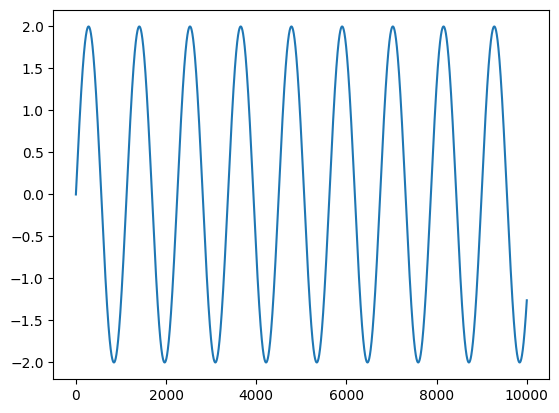

In [23]:
# Kick - a wave that is applied to the signal periodically, we choose a sine wave
phi = 0
f = 10 # Hz
A = 2
t = np.arange(10000)/sampling_frequency  # n = 10000, should be 50 in this case, but then the resolution is too low res =  sampling_frequency / frequency
kick = A * np.sin(2*np.pi*f*t + phi)
plt.plot(np.arange(10000), kick)

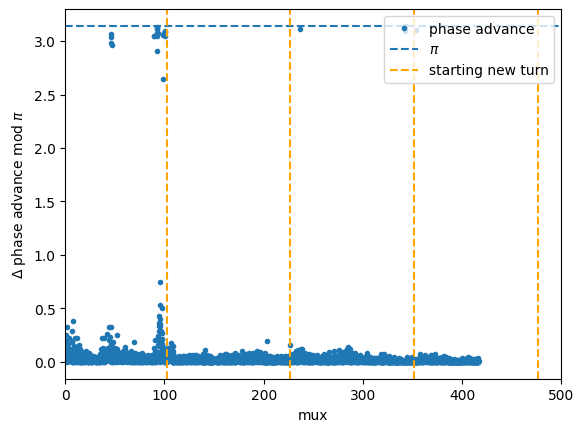

In [25]:
# find th sine wave that fits the data y = a*sin(2*pi*f*x + phi)
# find the phase advance for the first turn


mux_all_flat = np.array(mux_all).reshape(-1,1)
mux_all_flat1 = mux_all_flat.ravel()
mux_all_flat1 = mux_all_flat1[:4000].flatten()
x_list_norm1 = x_list_norm[:4000]

def my_fit(i, A, phi):
    return A*np.sin(2*np.pi*i + phi)

def sine_function(x, amplitude, phase):
    return amplitude * np.sin(2 * np.pi  * x + phase) 


number_bpms = 200
# Fit the sine function to the data
initial_guess = [1e-8,  0]  # Initial guess for the parameter
my_phase = []
for start_bpm in range(len(mux_all_flat1)-number_bpms):
    x=mux_all_flat1[(0+start_bpm):(number_bpms+start_bpm)]
    y=x_list_norm1[(0+start_bpm):(number_bpms+start_bpm)]

    fit_params, _ = curve_fit(sine_function, x, y, p0=initial_guess, maxfev = 1000000)
    my_phase.append(fit_params[1])

rounded_phases = np.round(np.array(my_phase), 4)  # Round to a reasonable precision, corrects for numerical noise
mod_pi_phases = rounded_phases % np.pi

plt.plot(mux_all_flat1[:-number_bpms-1], abs(np.diff(mod_pi_phases)), '.', label = 'phase advance')
plt.xlabel('mux')
plt.axhline(y = np.pi, label = '$\pi$', linestyle='dashed')
plt.ylabel('$\Delta$ phase advance mod $\pi$')
plt.autoscale(enable=True)
unique_labels = set()

for i in range(7):
    color = 'orange'
    label = 'starting new turn'
    plt.axvline(x=mux[-number_bpms-1] + mux[-1]* i, color=color, linestyle='dashed', label=label)

    # Add the label to the set to ensure it's only displayed once in the legend
    unique_labels.add(label)

# Create a custom legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_handles = []
unique_labels = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
plt.xlim(0,500)
plt.legend(unique_handles, unique_labels, loc ='upper right')

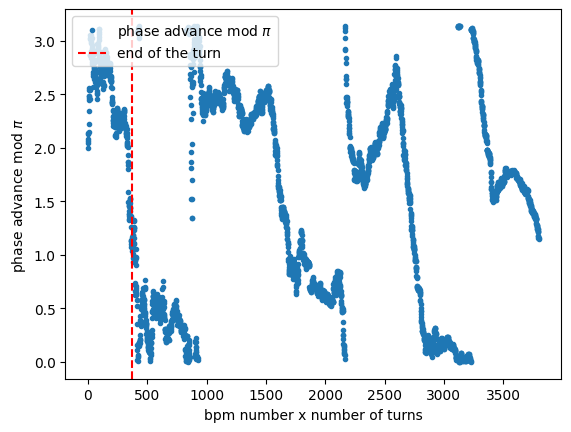

In [26]:
plt.plot(mod_pi_phases, '.', label = 'phase advance mod $\pi$')
plt.axvline(x = 568 - number_bpms+2, color = 'r', linestyle = '--', label = 'end of the turn')
plt.xlabel('bpm number x number of turns')
plt.ylabel('phase advance mod $\pi$')
plt.legend(loc ='upper left')